# Convolutional neural networks

## The convolution operation

Convolutional neural networks make use of the convolution operation. They are mostly used for processing image data with 2D discrete convolutions:

![convolution](figures/convolution.png)

## Let's try it out
Can you guess what the output image for convolutional kernel in the picture above will look like?

It's the Sobel operator (https://en.wikipedia.org/wiki/Sobel_operator) that can be used for edge detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

In [3]:
img = np.load("figures/grumpy.npy")

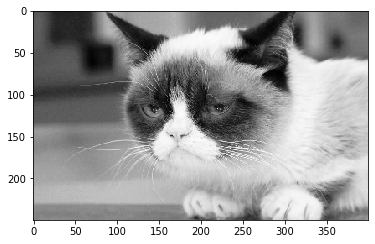

In [4]:
plt.imshow(img, cmap="Greys_r")

We could use `scipy.signal` to perform the convolution operation but to understand how the convolution works, let's quickly implement it by manually scanning over the image:

In [5]:
def convolve(input_img, kernel):
    # we will do a "valid" convolution
    # that means the output will be 2 pixels smaller in both directions than the input
    output_img = np.empty(shape=(input_img.shape[0]-2, input_img.shape[1]-2))
    for j in range(output_img.shape[1]):
        for i in range(output_img.shape[0]):
            output_img[i][j] = np.sum(kernel * input_img[i:i+kernel.shape[0], j:j+kernel.shape[1]])
    return output_img

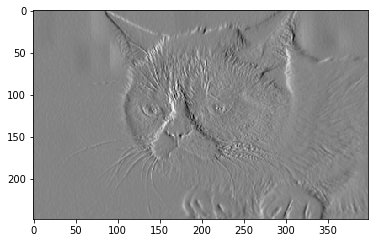

In [6]:
plt.imshow(convolve(img, sobel_x), cmap="Greys_r")

Vertical edges got highlighted! In a very simple example:

In [7]:
test_img = np.array([
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
    [0,0,0,0,1,1,1,1],
])

In [8]:
convolve(test_img, sobel_x)

array([[0., 0., 4., 4., 0., 0.],
       [0., 0., 4., 4., 0., 0.],
       [0., 0., 4., 4., 0., 0.],
       [0., 0., 4., 4., 0., 0.]])

The transposed filter will highlight horizontal edges:

In [9]:
sobel_y = sobel_x.T
sobel_y

array([[-1, -2, -1],
       [ 0,  0,  0],
       [ 1,  2,  1]])

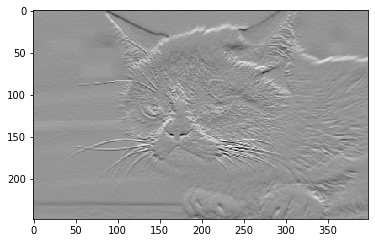

In [10]:
plt.imshow(convolve(img, sobel_y), cmap="Greys_r")

And if we quadratically add the pictures above we get a nice highlighting of all edges:

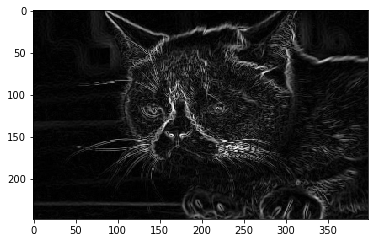

In [11]:
plt.imshow(
    np.sqrt(
        convolve(img, sobel_x)**2
        + convolve(img, sobel_y)**2
    ),
    cmap="Greys_r"
)

## Application within a neural network

You might imagine that such filters help a lot when processing images and e.g. trying to learn what they show. What a convolutional neural network (CNN) does is instead of using hand-designed filters have them as trainable parameters. We can then have layers with arbitrary many input features (each of them an image) and arbitrary many output features (each of them as well an image) by essentially sliding a neural network over them:

![cnn_layer](figures/cnn_layer.png)

The top row corresponds to the input features - before the first layer these are typically the 3 colors, red, green, blue and the bottom row corresponds to the output features. For each output feature, the neutral network will learn one convolutional kernel for each input feature. So the black lines in the graphic above correspond to the trainable weights.

[animated version](https://homepages.physik.uni-muenchen.de/~Nikolai.Hartmann/cnn_anim.svg)

In Addition to applying the filter one can (and typically will) also apply an activation function.

There is another nice animated visualisation in the [CS231 course](http://cs231n.github.io/) - here with a convolution of "stride 2" - meaning the filters move in steps of 2 pixels over the image:

In [12]:
from IPython.display import IFrame
IFrame('http://cs231n.github.io/assets/conv-demo/index.html', width=800, height=700)

## Pooling layers

In addition to convolutional layers, CNNs will typically perform some kind of downsampling in between. This has several reasons:

- The region of the orgininal image that the neural network can "see" will increase. This can help to make use of correlations between more distant areas within an image
- The amount of computation decreases (smaller images further down in the network) - more depth and/or width of the network can be increased
- Especially for classification problems the total NN output should a few numbers, e.g. indicating in which category an image falls. Successively downsampling the image within the network will help to keep the number of parameters in the last layers small.

Pooling typically takes the maximum, average or sum over a fixed sliding window. For exmaple Max pooling with a 2x2 window:

![max_pooling](figures/Max_pooling.png)


## Full CNN Architecture for image classification

A typical CNN architecture for image classification consists of several convolutional layers with pooling layers in between an a simple fully-connected network as a last step:

![max_pooling](figures/Typical_cnn.png)

The fully connected network either has all output pixels of the last convolutional/pooling layer as input ("flatten") or uses the global average of each output feature of the last convolutional/pooling layer

## Lets try it out - CIFAR10

We will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for trying CNNs. The dataset consists out of 60k 32x32 images, labelled for 10 categories. Our goal is to predict the category from processing the image.

In [13]:
from keras.datasets import cifar10

Using TensorFlow backend.


`data` will contain 2 tuples of x, y for training (50k) and testing (10k) data

In [14]:
data = cifar10.load_data()
x_train, y_train = data[0]
x_test, y_test = data[1]

pictures are aranged as arrays with indices (x, y, color)

In [15]:
x_train[0].shape

(32, 32, 3)

the target vector consists of label indices

In [16]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

The labels are as follows (in that order)

In [17]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Let's look at a few random pictures of cats

In [18]:
def show_random_pictures(x):
    pictures = x
    rnd_idx = np.random.permutation(len(pictures))
    fig, axs = plt.subplots(nrows=3, ncols=10, figsize=(20,6))
    for i, ax in enumerate(axs.reshape(-1)):
        ax.imshow(pictures[rnd_idx[i]])
        ax.set_axis_off()

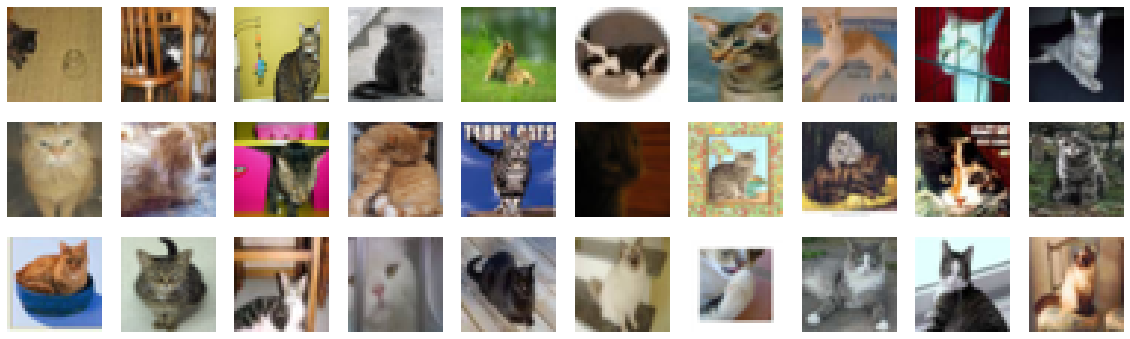

In [19]:
show_random_pictures(x_train[y_train.reshape(-1) == labels.index('cat')])

### Define the NN
Keras has all the components we need

In [20]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

Let's build a model similar to [keras/examples/cifar10_cnn.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)

In [21]:
model = keras.models.Sequential([
    # lets start with 2 convolutional layers with kernel size 3, 32 output features each
    Conv2D(32, 3, activation="relu", input_shape=(32, 32, 3)),
    Conv2D(32, 3, activation="relu"),
    # Max pooling (default window size is 2x2)
    MaxPooling2D(),
    # Add a 25% Dropout (randomly drops 25% of inputs during training)
    Dropout(0.25),
    # another block of 2 CNN layers with 64 output features each, followed by MaxPooling and Dropout
    Conv2D(64, 3, activation="relu"),
    Conv2D(64, 3, activation="relu"),
    MaxPooling2D(),
    Dropout(0.25),
    # Flatten (reshape) all output pixels of all features into 1D array
    Flatten(),
    # add a fully connected final hidden layer with 512 neurons, followed by 50% dropout
    Dense(512, activation="relu"),
    Dropout(0.5),
    # 10 output neurons that are supposed to represent the 10 categories
    # and output 1 if the image is likely in that category and 0 if not
    Dense(10, activation="softmax")
])

W0823 11:13:30.118966 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 11:13:30.215080 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 11:13:30.216850 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 11:13:30.232737 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool 

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

For a multi-classification problems the figure of merit to minimize is the categorical cross entropy. We will use the *Adam* optimizer - a state-of-the-art (2019) adaptive learning rate optimizer and tell keras to monitor the *accuracy* (fraction of correctly classified examples) during the training:

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

W0823 11:13:30.320576 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0823 11:13:30.340532 140414334588672 deprecation_wrapper.py:119] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



For preprocessing, we will simply divide by 255 (r, g, b values are between 0 and 255)

In [24]:
def preprocess(x):
    return x / 255.

Since the NN will output 10 values, we "one-hot-encode" our target vector

In [25]:
y_train_onehot = keras.utils.to_categorical(y_train)

In [26]:
y_train[:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

In [27]:
y_train_onehot[:10]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Now we are ready to start the training!

In [28]:
# these settings perform better for CPU training
# however, for some reason they don't mean that tf runs only one thread
# i have no idea what i'm doing ...
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1,
)
session = tf.Session(config=config)
K.set_session(session)

In [29]:
history = model.fit(
    # input
    preprocess(x_train),
    # target
    y_train_onehot,
    # number of training examples in each batch
    batch_size=64,
    # shuffle training data after each epoch
    shuffle=True,
    # number of iterations over training dataset
    epochs=5,
    # fraction of training data to split off for validation after each epoch
    validation_split=0.1,
)

W0823 11:13:31.124440 140414334588672 deprecation.py:323] From /home/n/Nikolai.Hartmann/conda/mlkurs/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 44s 986us/step - loss: 1.6160 - acc: 0.4071 - val_loss: 1.2406 - val_acc: 0.5516
Epoch 2/5
45000/45000 [==============================] - 45s 1ms/step - loss: 1.2250 - acc: 0.5613 - val_loss: 1.0015 - val_acc: 0.6514
Epoch 3/5
45000/45000 [==============================] - 45s 992us/step - loss: 1.0502 - acc: 0.6259 - val_loss: 0.9214 - val_acc: 0.6812
Epoch 4/5
45000/45000 [==============================] - 46s 1ms/step - loss: 0.9447 - acc: 0.6649 - val_loss: 0.8147 - val_acc: 0.7138
Epoch 5/5
45000/45000 [==============================] - 46s 1ms/step - loss: 0.8748 - acc: 0.6917 - val_loss: 0.8029 - val_acc: 0.7140


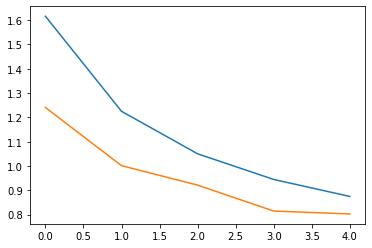

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [31]:
 np.min(history.history['val_loss'])

0.8029446202278138

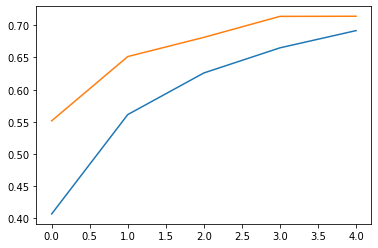

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

We got close to 70% accuracy on the validation sample! This is not perfect yet, but already quite impressive, given the relatively simple model and fast training. From the plots above we can see that the model is maybe not fully converged yet, so a few percent might be gained by continuing the training (you can try just executing the notebook cell above again).

[Current state-of-the art neural networks](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html) reach accuracies of > 95% on CIFAR-10, so there is still a lot of room for optimization.

But now, lets validate our score on the completely independent test sample:

In [33]:
scores = model.predict(preprocess(x_test))

These scores are now the predicted probabilities for each label

In [34]:
scores

array([[1.2263715e-03, 5.2048145e-03, 4.1849585e-03, ..., 4.1346168e-03,
        4.0535154e-03, 2.8055732e-03],
       [2.3455361e-03, 1.8096382e-03, 2.5237287e-06, ..., 2.1386827e-08,
        9.9570751e-01, 1.1839066e-04],
       [7.6552026e-02, 2.7057323e-01, 1.5161980e-02, ..., 4.7121765e-03,
        4.8757774e-01, 8.4886625e-02],
       ...,
       [7.0277376e-05, 5.1141114e-06, 2.7610360e-02, ..., 1.2897979e-01,
        9.5974458e-05, 1.4407528e-04],
       [1.5360512e-02, 6.4960949e-02, 2.0845093e-02, ..., 1.2622307e-03,
        1.8394419e-03, 4.6856920e-03],
       [2.8112729e-06, 1.0232150e-06, 6.3221832e-04, ..., 9.5672482e-01,
        1.2166075e-06, 9.1332231e-07]], dtype=float32)

When we take the index of the highest probability, we get the "best-guess" predicted labels

In [35]:
predicted_labels = np.argmax(scores, axis=1)
predicted_labels

array([3, 8, 8, ..., 5, 4, 7])

In [45]:
acc_test = (predicted_labels == y_test.reshape(-1)).mean()
acc_test

0.7115

For such multi class problems it is useful to plot a confusion matrix - telling us how often which label is confused with each of the other labels

In [36]:
from sklearn.metrics import confusion_matrix

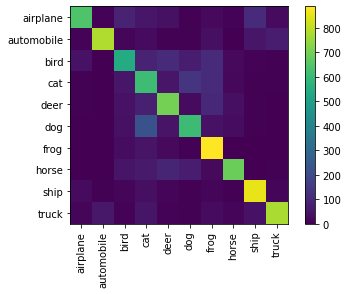

In [37]:
plt.imshow(confusion_matrix(y_test, predicted_labels))
plt.colorbar()
plt.xticks(range(10), labels, rotation=90)
plt.yticks(range(10), labels)
plt.show()

Our test sample has 10k pictures with 1k for each category, so the perfect confusion matrix would contain the value 1000 all over the diagonal. Overall we see that animals seem to be more difficult to distinguish than vehicles, and vehicles tend to be confused with other vehicles and animals with other animals.

Lets look at a random sample of pictures that our network classifies as "cats":

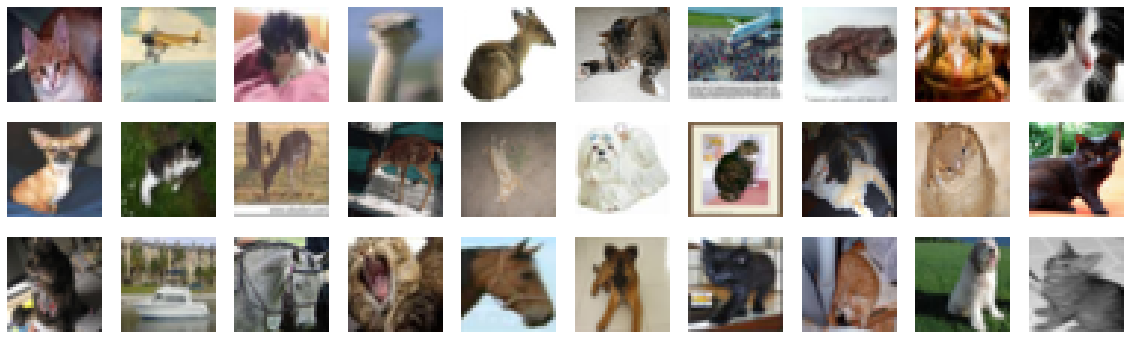

In [38]:
show_random_pictures(x_test[predicted_labels == labels.index('cat')])

Frogs seem to work rather well, but lets look in particular at images that are incorrectly classified as frogs:

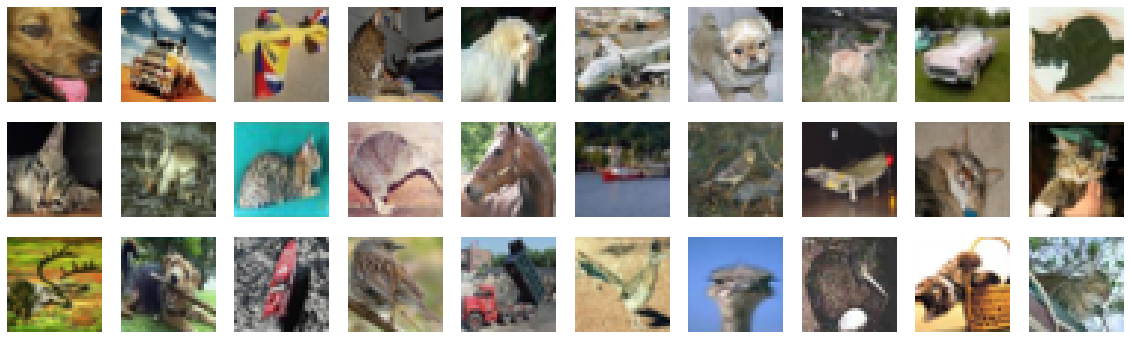

In [39]:
show_random_pictures(x_test[(predicted_labels == labels.index('frog')) & (y_test.reshape(-1) != labels.index('frog'))])

Seems like being in a green environment helps to be classified as a frog and also having a "froggy" texture. For comparison, some actual frogs:

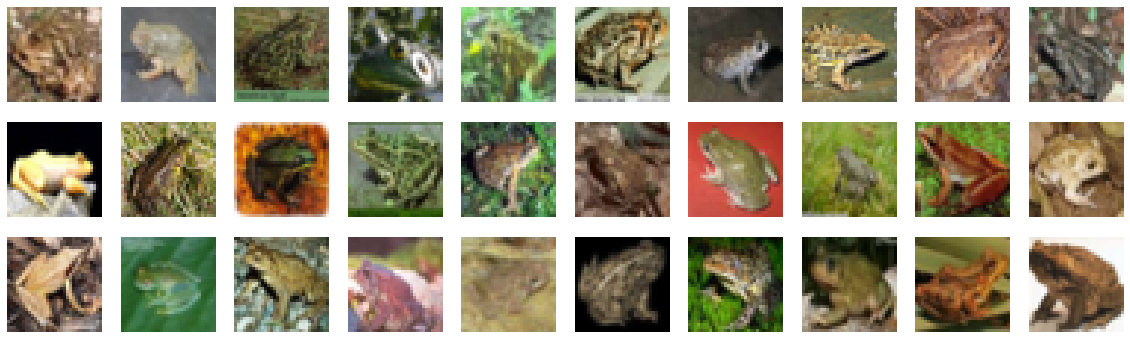

In [40]:
show_random_pictures(x_test[y_test.reshape(-1) == labels.index('frog')])

Lets have a look at the actual predicted probabilites for a few examples:

In [41]:
def plot_probabilities(x, scores, index):
    fig, ax = plt.subplots(figsize=(4, 2), nrows=1, ncols=2)
    ax[1].imshow(x[index])
    ax[1].set_axis_off()
    ax[0].barh(labels, scores[index])
    ax[0].set_xlabel("pred. probability")

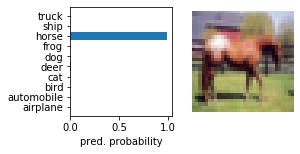

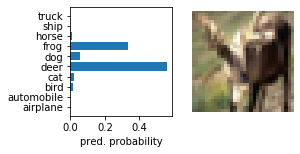

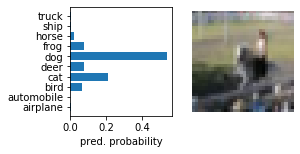

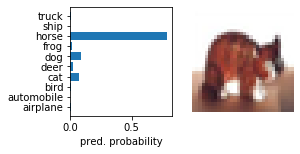

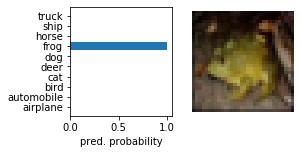

In [42]:
for index in np.random.randint(0, len(x_test), 5):
    plot_probabilities(x_test, scores, index)